In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:

X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/TBaptisteData/X.txt',index_col=None,delim_whitespace=True,header=None)

print(X_all)

          0       1       2       3       4       5       6       7       8
0    3.0312  1.0938  3.0312  1.0938  3.0312  0.5300  4.1875  0.0013  0.5750
1    1.0938  3.0312  1.0938  3.0312  1.0938  1.3300  2.5625  0.0038  0.8250
2    3.5156  3.5156  0.6094  2.5469  1.5781  0.7300  3.7812  0.0007  0.7625
3    2.5469  0.6094  1.5781  1.5781  0.6094  1.1300  4.5938  0.0044  0.6375
4    0.6094  2.5469  3.5156  3.5156  2.5469  0.3300  2.9688  0.0019  0.8875
..      ...     ...     ...     ...     ...     ...     ...     ...     ...
195  2.7815  2.8118  3.4778  3.4929  2.9631  1.4269  3.4956  0.0014  0.5643
196  3.7502  1.8430  2.5090  0.5867  3.9319  0.2269  4.3081  0.0026  0.9393
197  1.8127  3.7805  0.5715  2.5242  1.9944  1.0269  2.6831  0.0001  0.6893
198  1.3284  1.3586  3.9622  2.0398  3.4475  1.2269  2.2769  0.0020  0.7518
199  3.2659  3.2961  2.0247  3.9773  1.5100  0.4269  3.9019  0.0044  0.5018

[200 rows x 9 columns]


In [3]:

y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/TBaptisteData/X.txt',index_col=None,delim_whitespace=True,header=None)

print(y_all)

          0       1       2       3       4       5       6       7       8
0    3.0312  1.0938  3.0312  1.0938  3.0312  0.5300  4.1875  0.0013  0.5750
1    1.0938  3.0312  1.0938  3.0312  1.0938  1.3300  2.5625  0.0038  0.8250
2    3.5156  3.5156  0.6094  2.5469  1.5781  0.7300  3.7812  0.0007  0.7625
3    2.5469  0.6094  1.5781  1.5781  0.6094  1.1300  4.5938  0.0044  0.6375
4    0.6094  2.5469  3.5156  3.5156  2.5469  0.3300  2.9688  0.0019  0.8875
..      ...     ...     ...     ...     ...     ...     ...     ...     ...
195  2.7815  2.8118  3.4778  3.4929  2.9631  1.4269  3.4956  0.0014  0.5643
196  3.7502  1.8430  2.5090  0.5867  3.9319  0.2269  4.3081  0.0026  0.9393
197  1.8127  3.7805  0.5715  2.5242  1.9944  1.0269  2.6831  0.0001  0.6893
198  1.3284  1.3586  3.9622  2.0398  3.4475  1.2269  2.2769  0.0020  0.7518
199  3.2659  3.2961  2.0247  3.9773  1.5100  0.4269  3.9019  0.0044  0.5018

[200 rows x 9 columns]


# Emulator

In [4]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all.values)

In [5]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8


In [6]:
y_train[100]

tensor([5.9420e-01, 3.5308e+00, 3.5913e+00, 9.2720e-01, 3.8032e+00, 1.5238e+00,
        2.6006e+00, 1.3000e-03, 9.4800e-01], dtype=torch.float64)

In [7]:
nDim = X_all.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_all.iloc[:,i]),np.max(X_all.iloc[:,i])])
    print(boundsMaxMin[i])

[0.1553, 3.9924]
[0.1704, 3.9546]
[0.2385, 3.9924]
[0.1553, 3.9773]
[0.1704, 3.9849]
[0.1362, 1.7175]
[1.7627, 4.9937]
[0.0001, 0.005]
[0.4539, 0.948]


In [8]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [9]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = y_train[100]

In [10]:
boundsMaxMin

[[0.1553, 3.9924],
 [0.1704, 3.9546],
 [0.2385, 3.9924],
 [0.1553, 3.9773],
 [0.1704, 3.9849],
 [0.1362, 1.7175],
 [1.7627, 4.9937],
 [0.0001, 0.005],
 [0.4539, 0.948]]

In [11]:
np.array(boundsMaxMin)[:,0]*2

array([3.1060e-01, 3.4080e-01, 4.7700e-01, 3.1060e-01, 3.4080e-01,
       2.7240e-01, 3.5254e+00, 2.0000e-04, 9.0780e-01])

In [12]:
p0[0]

array([2.07389287e+00, 2.06245416e+00, 2.11547778e+00, 2.06627841e+00,
       2.07763618e+00, 9.26917675e-01, 3.37820122e+00, 2.55021760e-03,
       7.00934378e-01])

In [13]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [15]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],torch.ones(9)*0.01).detach().numpy())

In [16]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.01,0.01,0.01,0.01,0.01,0.01,0.01,1e-6,0.01])).detach().numpy())
    return ll

In [17]:
log_likelihood(p0[1],emulator,y_val)

-568.29346

In [18]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [20]:
p0[i].shape

(9,)

In [21]:
torch.tensor(p0[0]).shape

torch.Size([9])

In [22]:
emulator.predict(torch.tensor(p0)).shape

torch.Size([18, 9])

In [23]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-568.3206787109375
-568.29345703125
-568.3831176757812
-568.3175659179688
-568.261962890625
-568.3442993164062
-568.3081665039062
-568.3862915039062
-568.34228515625
-568.2882690429688
-568.311767578125
-568.2916259765625
-568.2852783203125
-568.35498046875
-568.2797241210938
-568.3328247070312


In [24]:
sampler.run_mcmc(p0, 40000)

State([[5.32327082e-01 3.50868371e+00 3.57612346e+00 9.18939683e-01
  3.84660642e+00 1.64161409e+00 2.59882004e+00 2.85273893e-04
  9.71135865e-01]
 [8.29728810e-01 3.69446360e+00 3.56426418e+00 9.33488200e-01
  3.75370787e+00 1.52940099e+00 2.57669454e+00 2.63282970e-03
  8.39232785e-01]
 [6.22127560e-01 3.47872617e+00 3.44181315e+00 9.94741884e-01
  3.71144780e+00 1.46909566e+00 2.57413907e+00 6.52232387e-04
  8.98411884e-01]
 [3.87784090e-01 3.49916409e+00 3.38866980e+00 8.84800668e-01
  3.64599351e+00 1.46850740e+00 2.62970482e+00 2.68727766e-03
  9.20957141e-01]
 [6.58872885e-01 3.57599658e+00 3.76523679e+00 1.00086833e+00
  3.81964106e+00 1.44372521e+00 2.62633381e+00 1.98536154e-03
  1.08128504e+00]
 [6.55817873e-01 3.48135592e+00 3.56697314e+00 9.49597020e-01
  3.87190661e+00 1.74452666e+00 2.47260145e+00 1.37602935e-03
  9.85176217e-01]
 [6.46998041e-01 3.50574645e+00 3.50864438e+00 1.01803249e+00
  3.65324259e+00 1.55691161e+00 2.46321714e+00 6.76165474e-04
  1.09343754e+00]


In [25]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

(576000, 9)


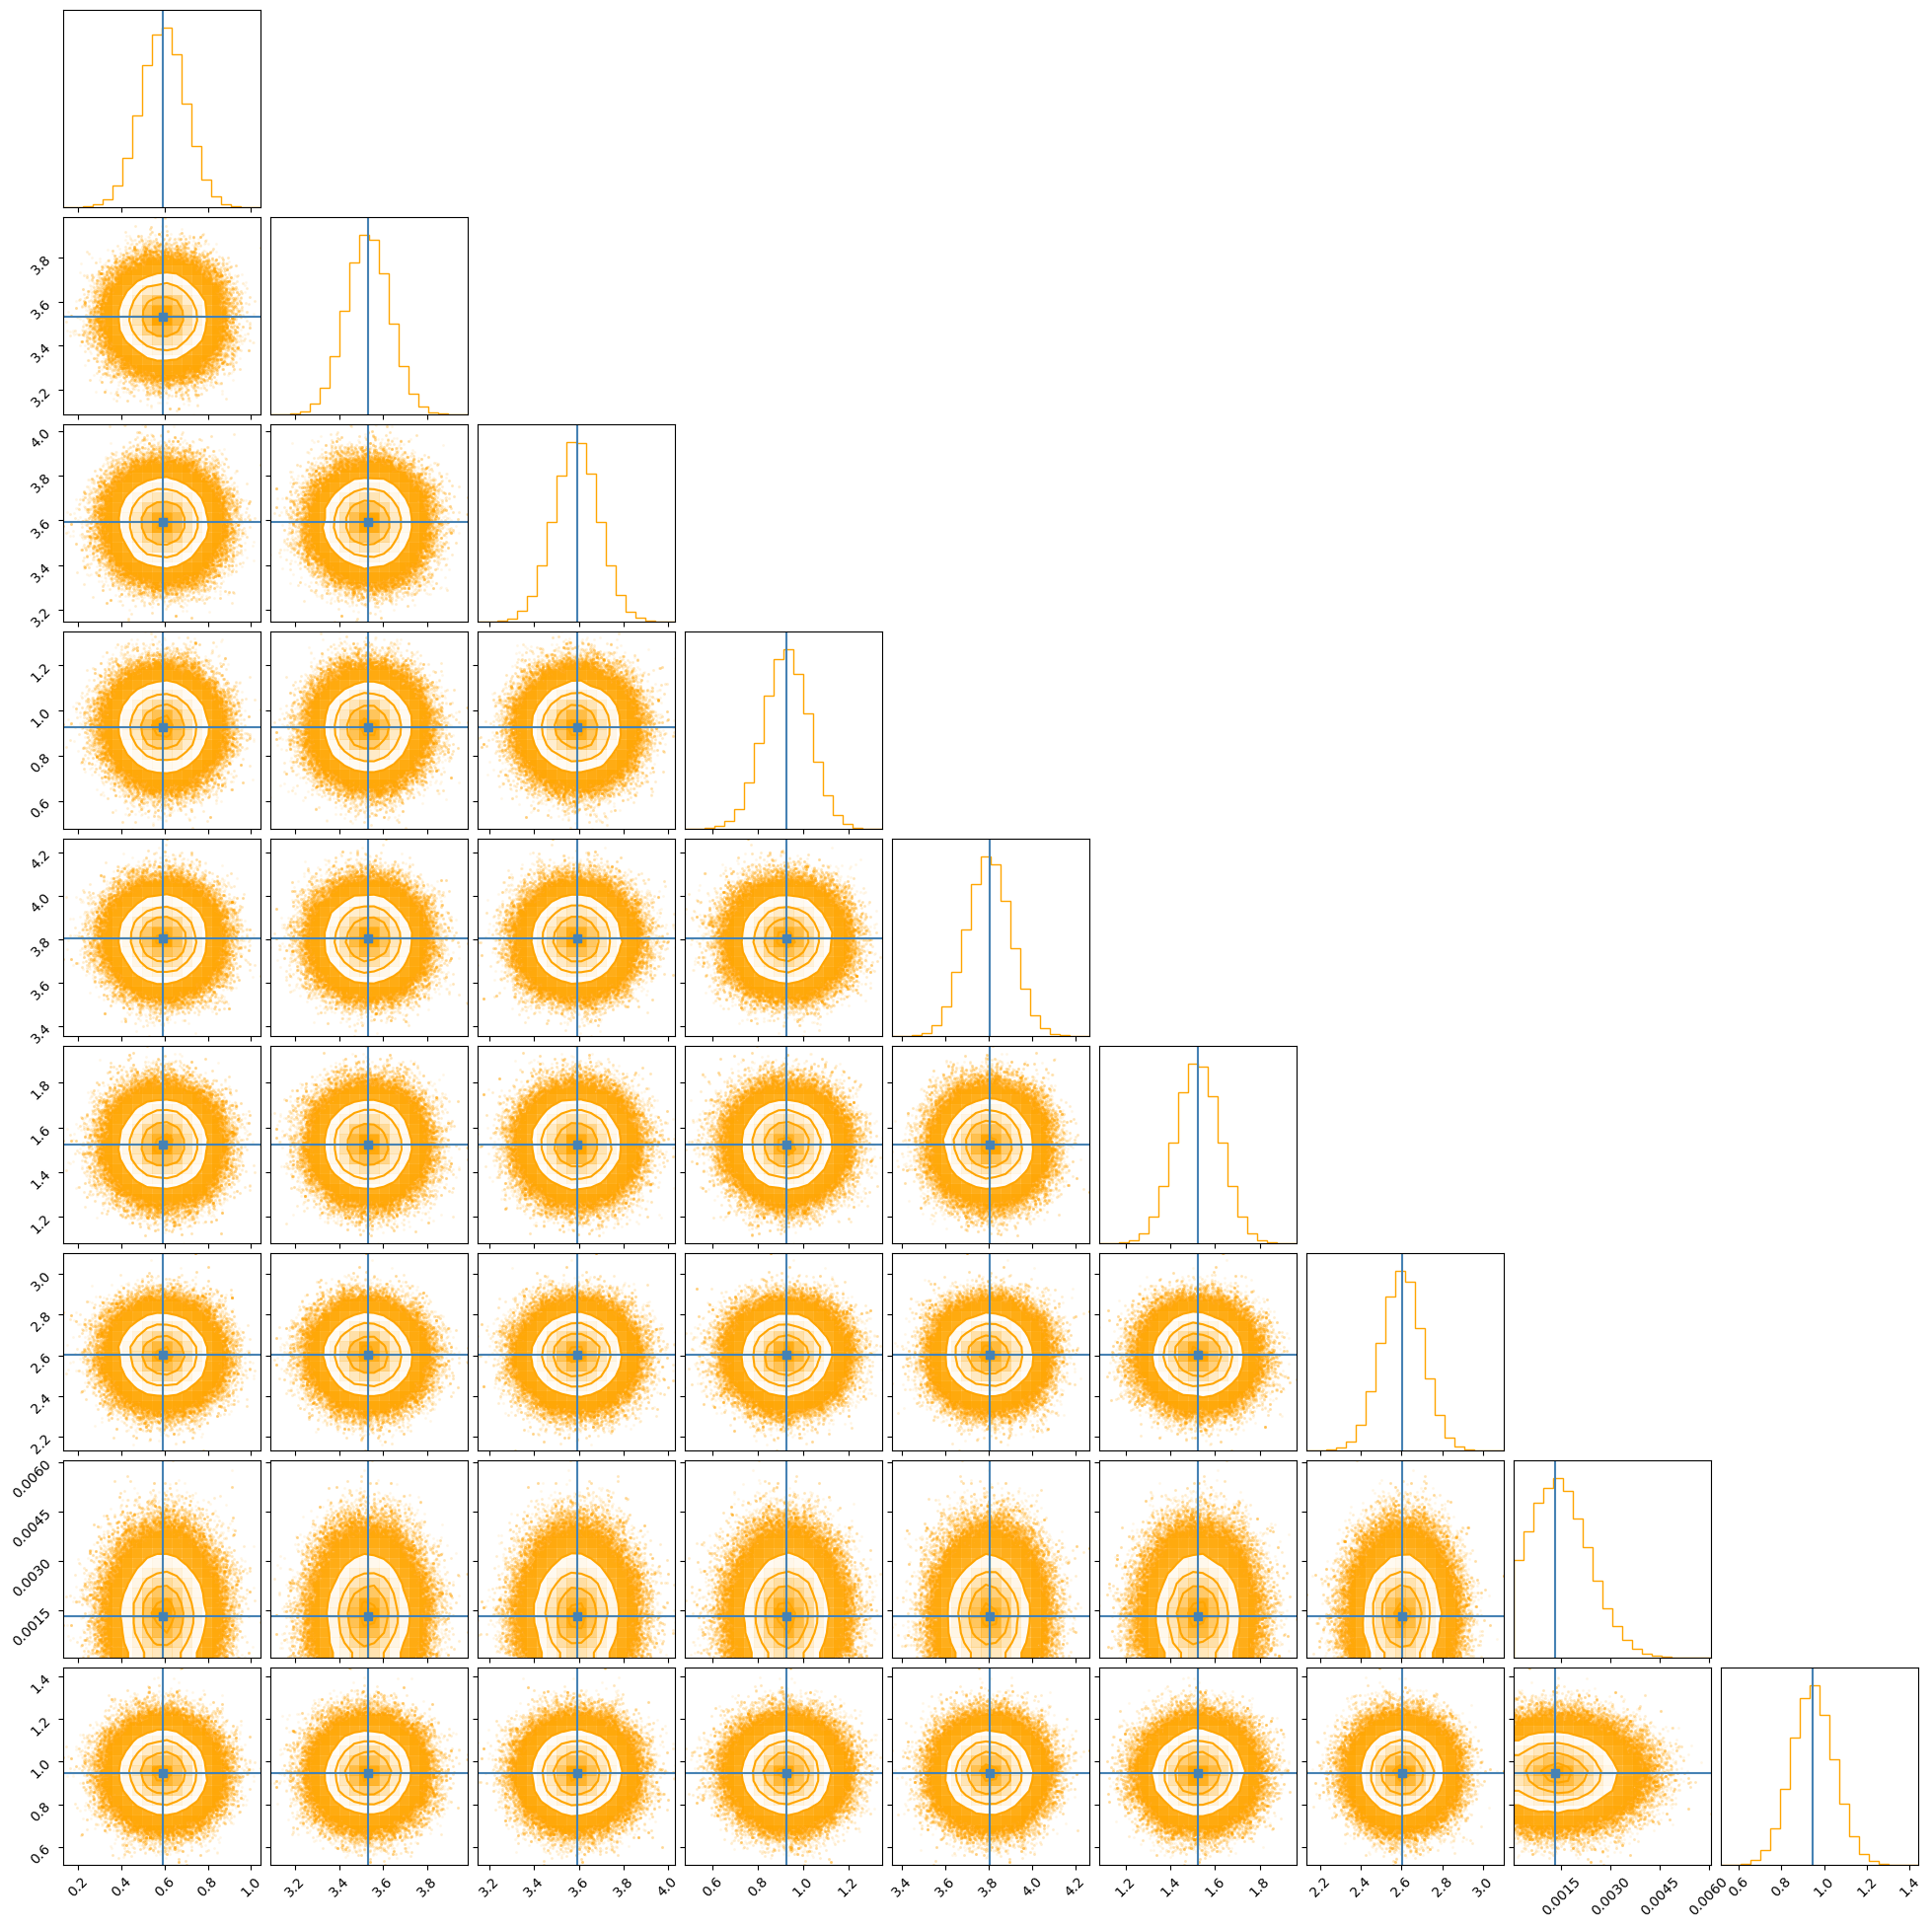

In [26]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_val
);

In [27]:
samp = pd.DataFrame(flat_samples).sample(50)

In [28]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [29]:
flat_samples.mean(axis=0)

array([5.94183111e-01, 3.53091906e+00, 3.58958660e+00, 9.26430867e-01,
       3.80018815e+00, 1.52404400e+00, 2.60147330e+00, 1.52149842e-03,
       9.47746164e-01])

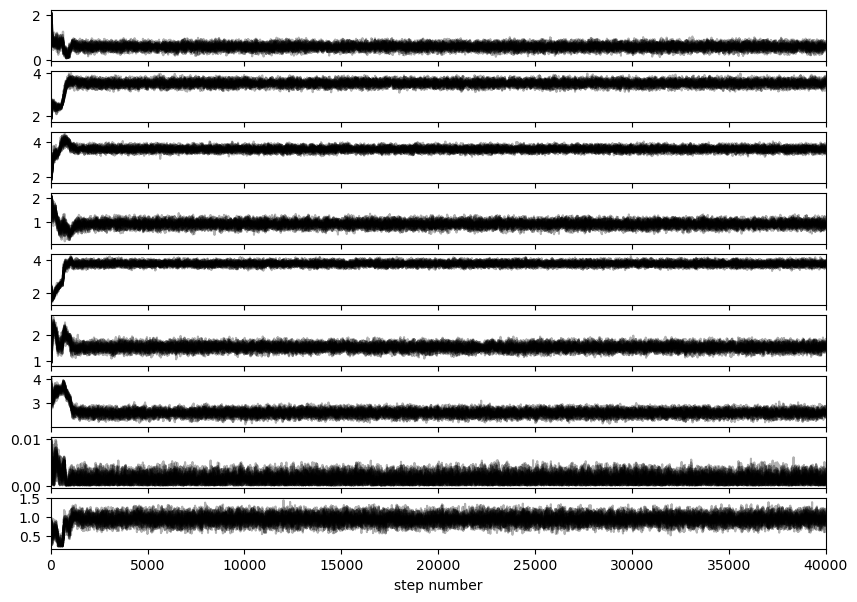

In [30]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [31]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [32]:
X_all.iloc[100]

0    0.5942
1    3.5308
2    3.5913
3    0.9272
4    3.8032
5    1.5238
6    2.6006
7    0.0013
8    0.9480
Name: 100, dtype: float64

In [33]:
emulator.predict(x_out[None,:])

tensor([[5.9452e-01, 3.5309e+00, 3.5892e+00, 9.2630e-01, 3.8002e+00, 1.5240e+00,
         2.6014e+00, 1.5215e-03, 9.4776e-01]], grad_fn=<PermuteBackward0>)

In [40]:
x_all=torch.tensor(X_all.values)

In [41]:
y_all=torch.tensor(y_all.values)


RuntimeError: Could not infer dtype of builtin_function_or_method

In [42]:
y_test = y_all[100,:]
x_test = x_all[100,:]

y_train = y_all[~torch.all(y_all == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]

In [43]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8


In [44]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [46]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-568.3145141601562
-568.2911987304688
-568.3681030273438
-568.31298828125
-568.2637329101562
-568.3359985351562
-568.3031005859375
-568.3722534179688
-568.331787109375
-568.2837524414062
-568.303955078125
-568.2874145507812
-568.2821655273438
-568.3447875976562
-568.279541015625
-568.3238525390625


In [47]:
sampler.run_mcmc(p0, 40000)

State([[7.31323886e-01 3.49353706e+00 3.64160902e+00 8.57868125e-01
  3.73089534e+00 1.54129058e+00 2.60661318e+00 8.66701765e-04
  9.24801653e-01]
 [7.35212031e-01 3.57709479e+00 3.68058144e+00 9.12499108e-01
  3.63797378e+00 1.31239037e+00 2.47964286e+00 6.32132687e-04
  8.15509545e-01]
 [4.20603305e-01 3.61116651e+00 3.32727865e+00 9.24537653e-01
  3.76843695e+00 1.55740933e+00 2.49815778e+00 1.89010582e-03
  1.04339561e+00]
 [7.26668013e-01 3.54385406e+00 3.58494500e+00 6.94171479e-01
  3.78134177e+00 1.68431168e+00 2.66281931e+00 1.31626140e-03
  1.06227857e+00]
 [5.99675554e-01 3.43317017e+00 3.37082406e+00 7.18869251e-01
  3.84009831e+00 1.43740604e+00 2.50359470e+00 3.59367726e-03
  1.00227894e+00]
 [5.77977571e-01 3.44764263e+00 3.74632222e+00 1.03301203e+00
  3.97893292e+00 1.43133057e+00 2.59471087e+00 3.03895499e-03
  9.15449840e-01]
 [7.99409292e-01 3.54074810e+00 3.38191640e+00 9.68734316e-01
  3.67252033e+00 1.52326936e+00 2.59591076e+00 2.16209492e-03
  1.10827264e+00]


In [48]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

(576000, 9)


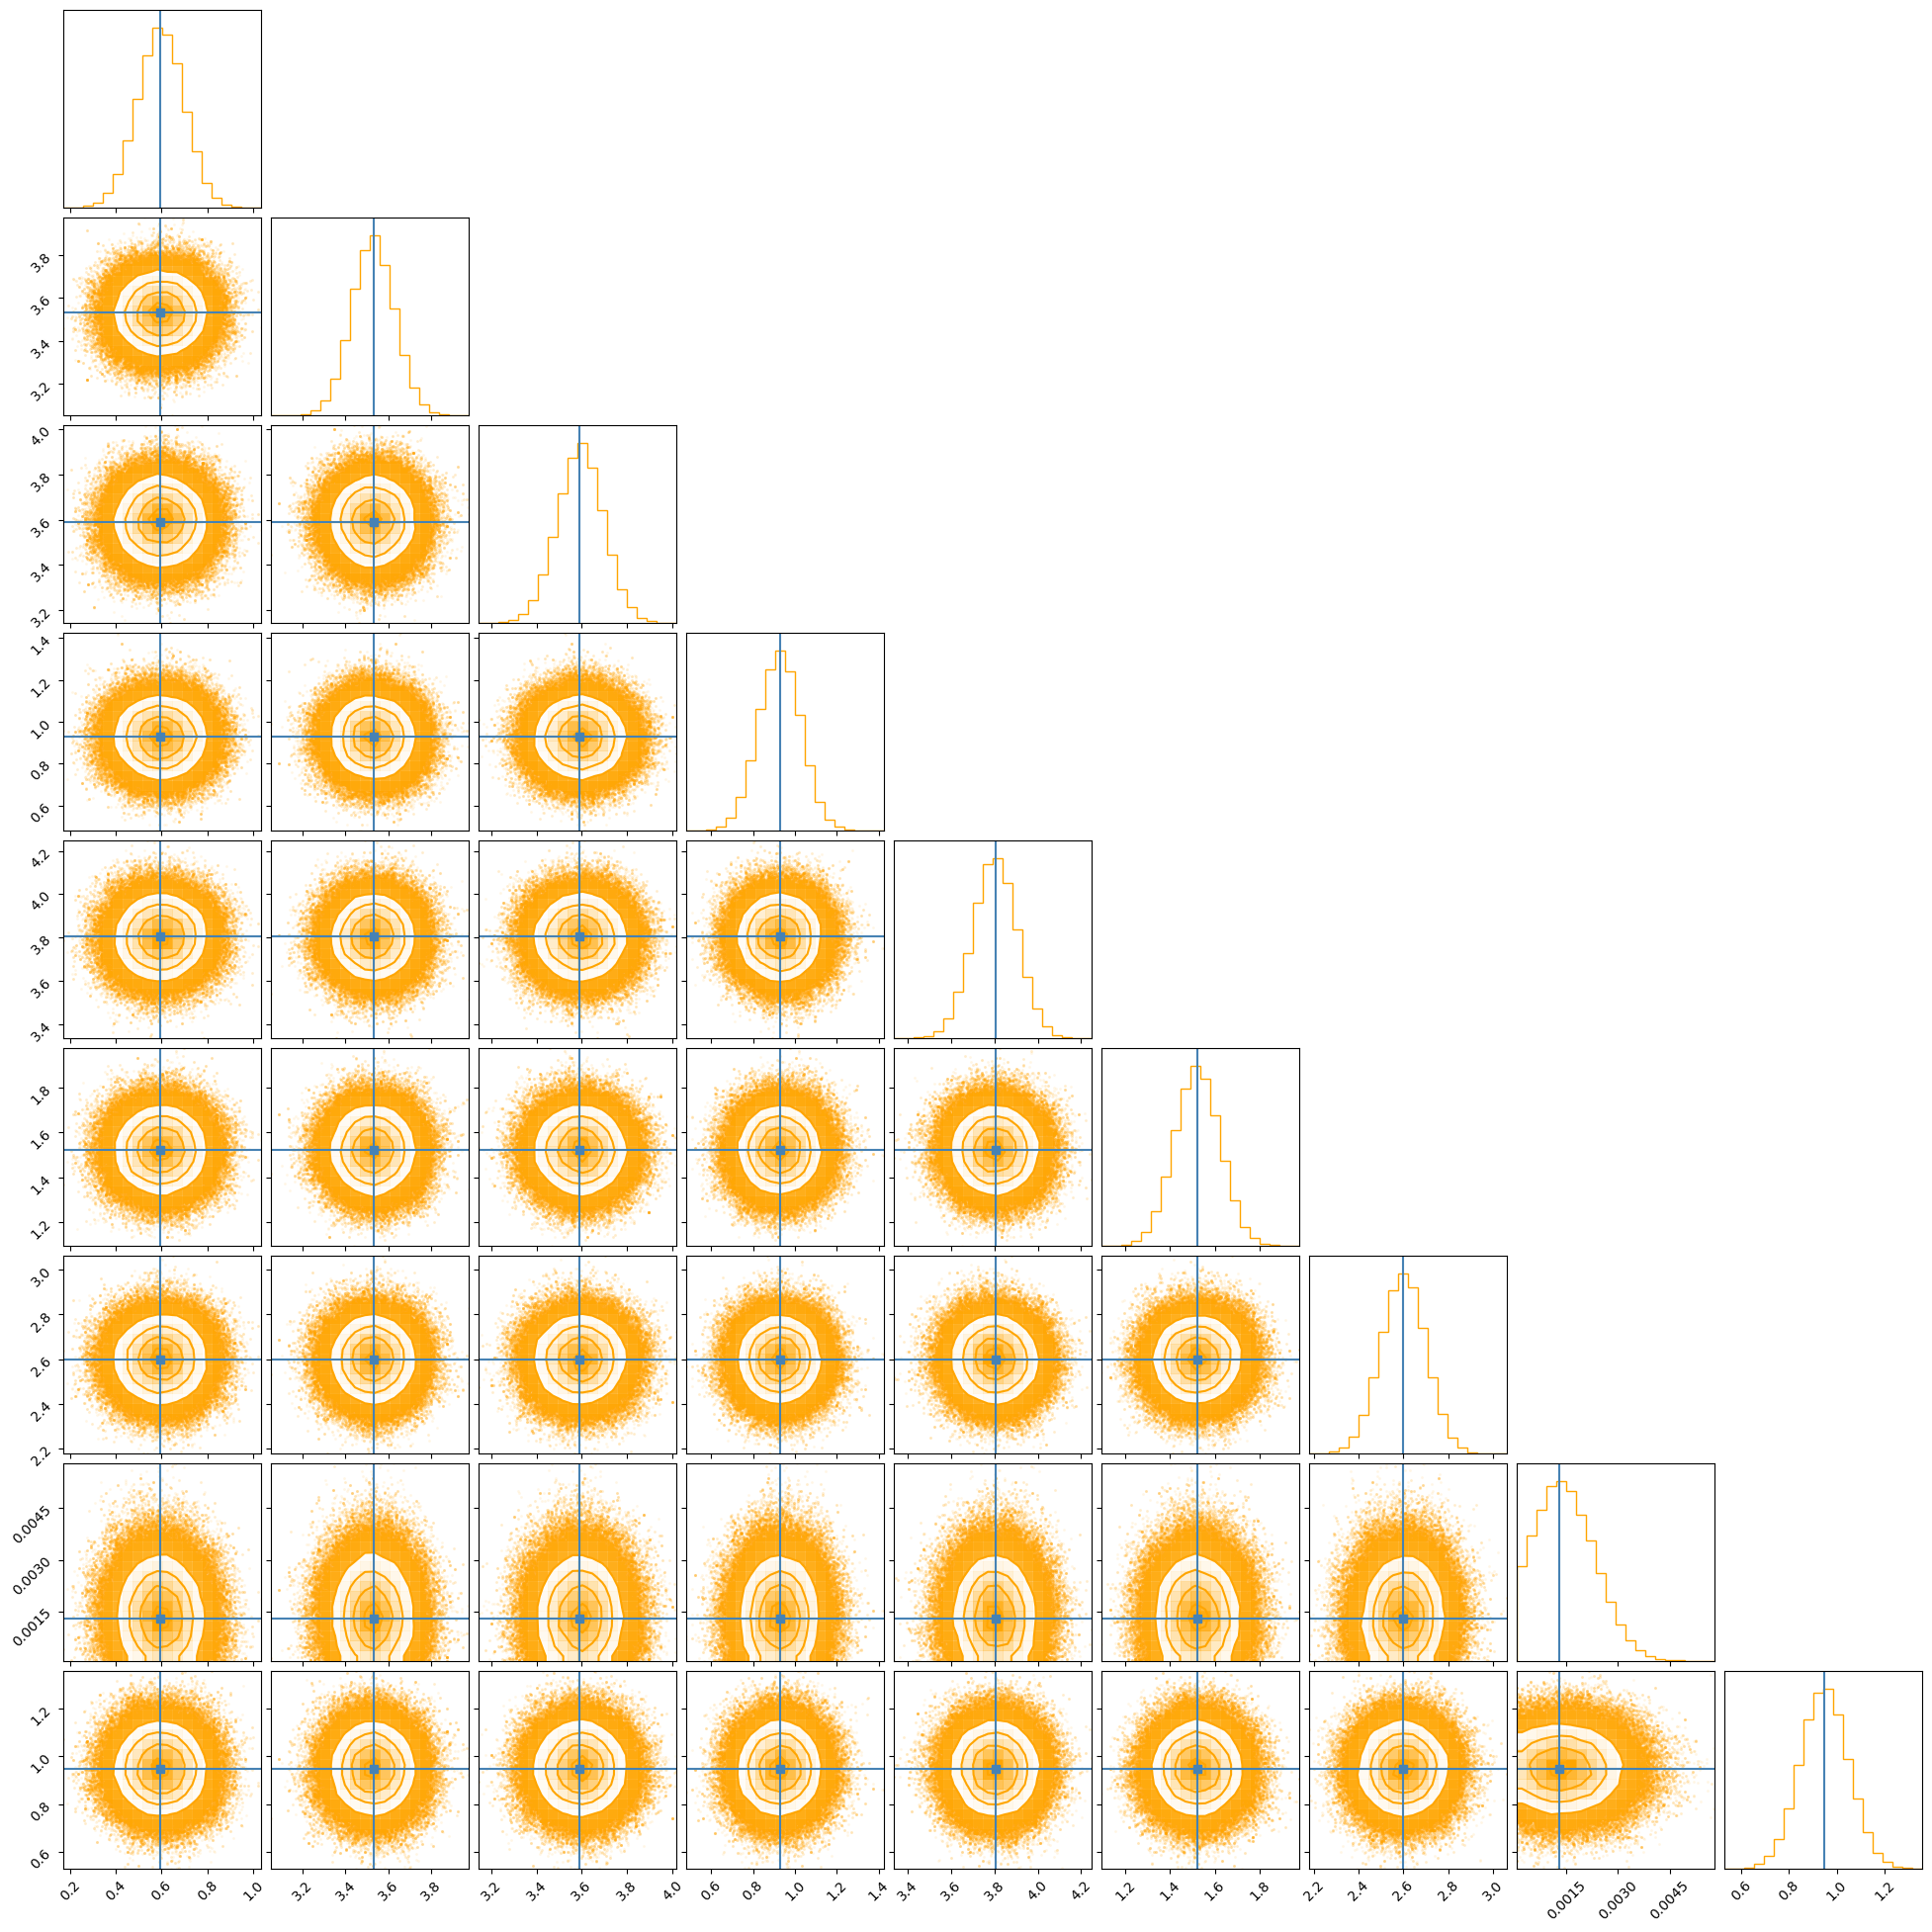

In [50]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_test
);